**Part 1: Setup and Dataset Preparation**

In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize image data to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class labels to one-hot encoding (e.g., 2 -> [0, 0, 1, 0, ..., 0])
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}, Test data shape: {x_test.shape}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 210s 1us/step
Training data shape: (50000, 32, 32, 3), Test data shape: (10000, 32, 32, 3)


**Part 2: Define the ResNet-18 Architecture**

In [2]:
# Define a single residual block for ResNet
def resnet_block(input_tensor, filters, strides=1):
    # First convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if strides != 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), strides=strides, use_bias=False)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    # Add the shortcut to the main path
    x = layers.Add()([x, input_tensor])
    x = layers.ReLU()(x)
    return x

# Build the full ResNet-18 model
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add ResNet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    # Global Average Pooling and final classification layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = models.Model(inputs, outputs)
    return model


**Part 3: Define the Generator for Synthetic Data**

In [3]:
# Define a simple generator for producing synthetic images
def create_generator():
    generator = models.Sequential([
        layers.Dense(8 * 8 * 128, activation="relu", input_dim=100),
        layers.Reshape((8, 8, 128)),  # Reshape latent vector into 8x8x128 tensor
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2D(3, (3, 3), activation="tanh", padding="same")  # Output: 32x32x3 image
    ])
    return generator

# Create an instance of the generator
generator = create_generator()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Part 4: Utility Functions for Synthetic Data and Dataset Mixing**

In [4]:
# Generate synthetic images using the generator
def generate_images(generator, num_images):
    # Generate random noise (latent vector) as input to the generator
    noise = np.random.normal(0, 1, (num_images, 100))

    # Generate synthetic images and rescale from [-1, 1] to [0, 1]
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0
    return generated_images

# Mix real and synthetic datasets based on a contamination ratio
def mix_datasets(real_images, real_labels, synthetic_images, synthetic_labels, ratio):
    # Calculate the number of real and synthetic samples
    num_real = int(len(real_images) * (1 - ratio))
    num_synthetic = len(real_images) - num_real

    # Combine real and synthetic data
    mixed_images = np.concatenate([real_images[:num_real], synthetic_images[:num_synthetic]])
    mixed_labels = np.concatenate([real_labels[:num_real], synthetic_labels[:num_synthetic]])

    # Shuffle the combined dataset
    indices = np.arange(len(mixed_images))
    np.random.shuffle(indices)
    return mixed_images[indices], mixed_labels[indices]


**Part 5: Image Classification with Synthetic Data**

In [5]:
# Perform image classification with varying contamination ratios
def image_classification(generator, contamination_ratios):
    # Generate synthetic images and labels
    synthetic_images = generate_images(generator, len(x_train))
    synthetic_labels = np.random.randint(0, 10, len(x_train))
    synthetic_labels = to_categorical(synthetic_labels, 10)

    results = []  # To store results for each contamination ratio

    for ratio in contamination_ratios:
        print(f"\nTraining with {int(ratio * 100)}% synthetic data...")

        # Create a mixed dataset
        x_mixed, y_mixed = mix_datasets(x_train, y_train, synthetic_images, synthetic_labels, ratio)

        # Build and compile the ResNet-18 model
        resnet18 = build_resnet18()
        resnet18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = resnet18.fit(x_mixed, y_mixed, epochs=10, batch_size=64,
                               validation_data=(x_test, y_test), verbose=1)

        # Evaluate the model and generate confusion matrix
        y_pred = np.argmax(resnet18.predict(x_test), axis=1)
        y_true = np.argmax(y_test, axis=1)
        confusion = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=list(range(10))).plot()

        # Store results
        results.append({
            'ratio': ratio,
            'train_accuracy': history.history['accuracy'][-1],
            'val_accuracy': history.history['val_accuracy'][-1]
        })

    # Plot validation accuracy vs contamination ratio
    plt.figure(figsize=(8, 6))
    plt.plot([r['ratio'] for r in results], [r['val_accuracy'] for r in results], marker='o', label='Validation Accuracy')
    plt.xlabel('Synthetic Data Ratio')
    plt.ylabel('Validation Accuracy')
    plt.title('Impact of Synthetic Data on Classification')
    plt.grid(True)
    plt.legend()
    plt.show()


**Part 6: Execute the Task**

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Training with 0% synthetic data...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.4509 - loss: 1.5646 - val_accuracy: 0.4603 - val_loss: 2.3243
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.7324 - loss: 0.7661 - val_accuracy: 0.5289 - val_loss: 1.8248
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.8108 - loss: 0.5474 - val_accuracy: 0.7088 - val_loss: 0.9391
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8562 - loss: 0.4122 - val_accuracy: 0.7449 - val_loss: 0.8083
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.8929 - loss: 0.3086 - val_accuracy: 0.7352 - val_loss: 0.8769
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 65ms/step - accuracy: 0.9212 - loss: 0.2268 - val_accuracy: 0.8150 - val_loss: 0.5886
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.9458 - loss: 0.1524 - val_accuracy: 0.8203 - val_loss: 0.6092
Epoch 8/10


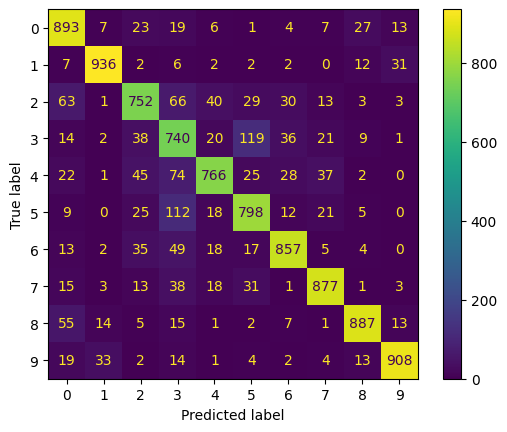

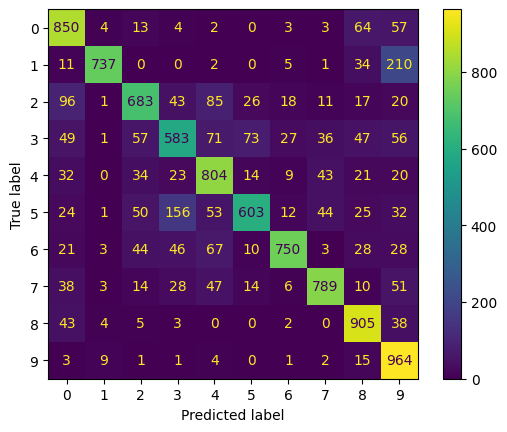

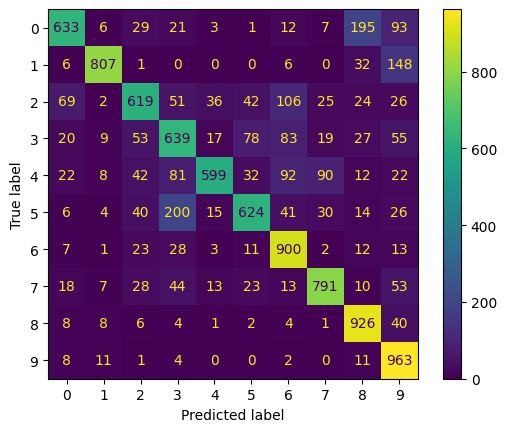

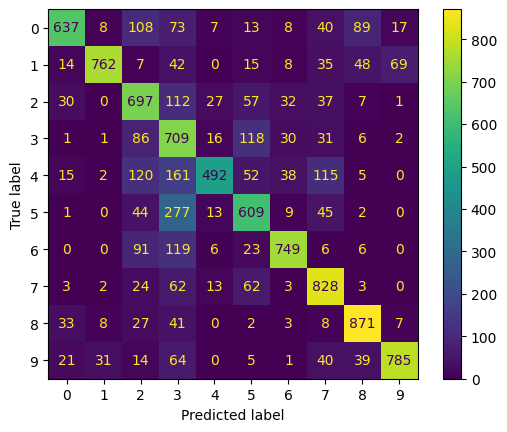

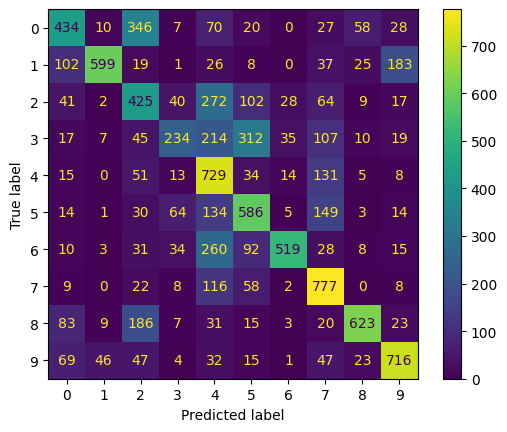

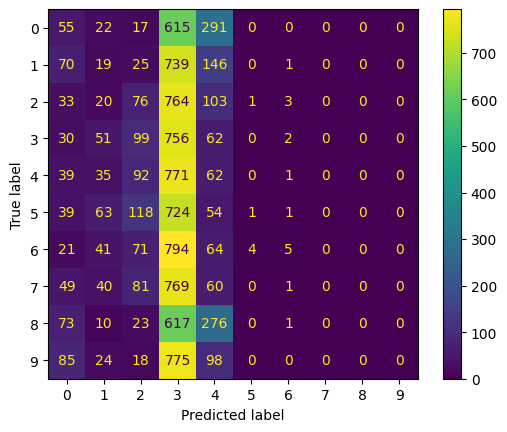

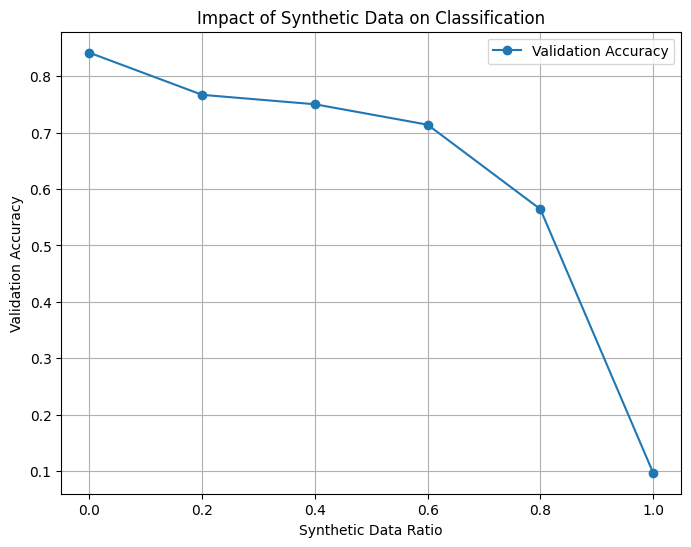

In [6]:
# Define contamination ratios
contamination_ratios = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Execute the image classification task
image_classification(generator, contamination_ratios)
